In [1]:
from mnist import MNIST
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [2]:
mntrain = MNIST('../samples')

In [3]:
img_tr,lbl_tr = mntrain.load_training()
img_ts,lbl_ts = mntrain.load_testing()
img_size = 28 # 28x28 pixels

Label:  4


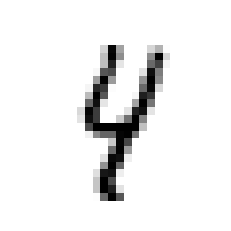

In [4]:
index = random.randrange(0,len(img_tr))
print("Label: ",lbl_tr[index])
image = np.array(img_tr[index]).reshape(img_size,img_size)
plt.imshow(image, cmap=plt.cm.binary)
plt.gcf().axes[0].set_axis_off()

In [8]:
x = [0,1,2,3,4,5,6,7,8,9]
list(reversed(x))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [5]:
np.matmul(np.zeros((5,2)),np.array([4,5]))

array([0., 0., 0., 0., 0.])

In [139]:
weights = np.random.rand(5, 2)
biases = np.random.rand(5,1)
for i,j in weights:
    print(i,j)
print(weights)

0.4108819835872173 0.48027544561705193
0.7846679138240524 0.23005638333957856
0.5473621735107193 0.47025677829583956
0.39910668272713445 0.6513959268059999
0.3108400329758101 0.43645317358419444
[[0.41088198 0.48027545]
 [0.78466791 0.23005638]
 [0.54736217 0.47025678]
 [0.39910668 0.65139593]
 [0.31084003 0.43645317]]


In [149]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def d_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
def d_sig(x):
    return x*(1-x)

class Layer:
    def __init__(self, depth, length,values=None):
        self.depth = depth
        self.length = length
        self.nodes = np.array([values for i in range(length)]) if values else np.zeros(length)
    def __str__(self):
        return "Layer: depth: %d, length: %d, nodes: %s" % (self.depth, self.length, self.nodes)
    def __repr__(self):
        return self.__str__()
    def __getitem__(self, index):
        return self.nodes[index]
    def __setitem__(self, index, value):
        self.nodes[index].value = value
    def __iter__(self):
        return iter(self.nodes)
    def __len__(self):
        return len(self.nodes)
    def __contains__(self, item):
        return item in self.nodes
    def __delitem__(self, index):
        del self.nodes[index]
    
    def get_values(self):
        return self.nodes
    def set_values(self, values):
        self.nodes = np.array(values)
    values = property(get_values, set_values)

    
class Neurons:
    def __init__(self, layer1, layer2):
        self.layer1 = layer1
        self.layer2 = layer2
        self.weights = np.random.rand(len(layer2), len(layer1))
        self.biases = np.random.rand(len(layer2))

            
    def __str__(self):
        return "Layer_Connection: layer1: %s, layer2: %s, weights: %s, biases: %s" % (self.layer1, self.layer2, self.weights, self.biases)
    def __repr__(self):
        return self.__str__()
    def __getitem__(self, index):
        return self.weights[index]
    def __setitem__(self, index, value):
        self.weights[index] = value
    def __iter__(self):
        return iter(self.weights)
    def __len__(self):
        return self.weights.shape[0] * self.weights.shape[1]
    def __contains__(self, layer):
        return layer in (self.layer1, self.layer2)
    def __delitem__(self, index):
        del self.weights[index]


class Neural_Network:
    def __init__(self, input_size, output_size,hidden_size, hidden_layers=1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = [Layer(0, input_size)]
        self.layers.extend([Layer(i+1, hidden_size) for i in range(hidden_layers)])
        self.layers.append(Layer(hidden_layers+1, output_size))
        self.neurons = [Neurons(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)]
    
    def __str__(self):
        return "Neural_Network: input_size: %d, hidden_size: %d, output_size: %d, hidden_layers: %d, layers: %s, connections: %s" % (self.input_size, self.hidden_size, self.output_size, len(self.layers)-2, self.layers, self.neurons)
    def __repr__(self):
        return self.__str__()
        
    def output_vector(self):
        return self.layers[-1].values
    
    def output(self):
        return np.argmax(self.output_vector())
    
    def feed_forward(self, image):
        self.layers[0].values = image
        for j in self.neurons:
            j.layer2.values = sigmoid(np.matmul(j.weights, j.layer1.values) - j.biases)
  

    def back_propagate(self, expected, factor):
        print(expected)
        for i in reversed(self.neurons):
            diff = i.layer2.values - expected
            der = d_sig(i.layer2.values)
            coeff = factor * 2 * diff * der

            expected = np.matmul(i.weights.T, diff)
            print(i.weights.shape, diff.shape,coeff.shape,expected.shape)
            for k, j in i.weights:
                i.weights[k][j] -= coeff[k] * i.layer1.values[j]
            print(i.weights.shape)
            i.biases = coeff
            
            
            
            
            # j = self.neurons[i]
            # if i == len(self.neurons)-1:
            #     error = expected - j.layer2.values
            # else:
            #     error = np.matmul(self.neurons[i+1].weights.T, error)
            # delta = error * j.layer2.values * (1-j.layer2.values)
            # j.weights += factor * np.matmul(delta.reshape(len(delta),1), j.layer1.values.reshape(1,len(j.layer1.values)))
            # j.biases += factor * delta
            #print(j.weights)
            #print(j.biases)
            #print(error)
            #print(delta)
    
    def test(self, images, labels):
        correct = 0
        for i in tqdm(range(len(images))):
            self.feed_forward(images[i])
            if self.output() == labels[i]:
                correct += 1
        return correct/len(images)

              
    def train(self, images, labels, epochs=1, factor=0.1):
        for _ in range(epochs):
            for j in tqdm(range(len(images))):

                self.feed_forward(images[j])
                expected = np.zeros(self.output_size)
                expected[labels[j]] = 1
                self.back_propagate(expected,factor)

In [150]:
nn = Neural_Network(784, 10, 16, 1)

In [151]:
nn.train(img_tr,lbl_tr, 1, 0.1)

  0%|          | 0/60000 [00:00<?, ?it/s]

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(10, 16) (10,) (10,) (16,)


ValueError: too many values to unpack (expected 2)

In [71]:
nn.test(img_ts,lbl_ts)

100%|██████████| 10000/10000 [00:01<00:00, 8486.84it/s]


0.0892

In [35]:
nn.layers[1].values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [173]:
nn.back_propagate(lbl_tr[0])

In [155]:

nn.feed_forward(img_tr[0])
nn.output_vector()

array([0.9998988 , 0.99990402, 0.99971381, 0.99978931, 0.99950158,
       0.99988421, 0.99964177, 0.99985457, 0.99996816, 0.999723  ])